<a href="https://colab.research.google.com/github/EmmanuelABonsu/CE888/blob/main/src/lab4-recommender/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv", delimiter = ",", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [3]:
# Replacing 99 with Nan
df = df.replace(99, np.NaN)
print(df.shape)
df.head()

(24983, 101)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
# Dropping the first column (Corresponding to the total number of jokes)
df = df.drop(0, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [8]:
# Worst Rated Joke
df.mean(axis = 0, skipna = True).idxmin()

58

In [10]:
# # Worst Rated Joke Mean Rating
min(df.mean(axis = 0, skipna = True))

-3.8338796373689923

In [11]:
# Best Rated joke
df.mean(axis = 0, skipna = True).idxmax()

50

In [12]:
# Best Rated Jokes
max(df.mean(axis = 0, skipna = True))

3.6650848950824937

In [14]:
# Convert dataframe to numpy array
arr = df.values
arr

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

In [15]:
# Check Shape
arr.shape

(24983, 100)

In [42]:
# User 10168 Rating of joke 26
arr[8277][28]

-9.9

In [17]:
rated = np.where(~np.isnan(arr))


In [18]:
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [19]:
# Modifying Helper Function
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(~np.isnan(new_data))
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])


In [20]:
new_arr, idx = replace(arr, 0.1)
new_arr

array([[99.  ,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ..., 99.  , -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

In [21]:
n_latent_factors = 2
# Initialise as random values
latent_user_preferences = np.random.random((new_arr.shape[0], n_latent_factors))
latent_item_features = np.random.random((new_arr.shape[1], n_latent_factors))

In [22]:
def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err

In [23]:
def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = new_arr[user_id, item_id]
                if not np.isnan(rating) and rating != 99:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10000) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [24]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)

Iteration 0/10:	MSE=26.204293


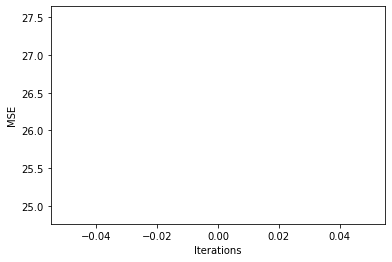

In [25]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 10), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [26]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.7185051 , 1.02100362, 1.05431056, ..., 1.95722339, 0.74217909,
        2.56544835],
       [1.41760345, 0.89350435, 0.88041932, ..., 1.58159946, 0.77571124,
        2.06900625],
       [1.46578431, 0.87577671, 0.90029331, ..., 1.66623756, 0.64872382,
        2.18364357],
       ...,
       [0.50168765, 0.28895588, 0.30588448, ..., 0.57722601, 0.18762447,
        0.75733073],
       [0.64518085, 0.32708213, 0.38407142, ..., 0.77091292, 0.09933418,
        1.01496645],
       [1.27905887, 0.70488535, 0.77320949, ..., 1.49207161, 0.37692152,
        1.96013592]])

In [27]:
values = [zip(new_arr[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = df.columns

In [28]:
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(99.0, 1.718505103058076)","(8.79, 1.0210036151382735)","(-9.66, 1.0543105629963383)","(-8.16, -1.1043292041784873)","(-7.52, 1.088238469257597)","(-8.5, 2.893633065519161)","(-9.85, -0.060543780545852244)","(4.17, -0.49771576623416236)","(-8.98, -0.1355173067225103)","(-4.76, 2.184387883981084)","(-8.5, 3.057213262082471)","(-6.75, 2.8483062838060795)","(-7.18, -1.9175156042065862)","(8.45, 2.7983912860402906)","(-7.18, -2.0259164654168327)","(-7.52, -3.7929924055168938)","(-7.43, -0.9688061976176053)","(-9.81, -0.5058927137562927)","(-9.85, 0.7785576358375311)","(-9.85, -0.6207345907743189)","(-9.37, 3.6251553362364723)","(99.0, 1.9572921284087683)","(-4.37, 0.8057514185631478)","(-9.81, -1.5990249965659729)","(-8.5, 1.3424650632795643)","(1.12, 2.6124017332055116)","(7.82, 4.798311024614966)","(2.86, 2.7806877046380234)","(9.13, 4.5599312233007785)","(99.0, 0.24650380538608957)","(99.0, 3.7065845238074715)","(-4.08, 4.810925275074836)","(-9.08, -0.9521498321685807)","(7.82, 2.113460614923376)","(5.05, 4.636797379632505)","(99.0, 4.861411424238348)","(-9.17, -1.1874327590060485)","(-8.4, 2.3502313475173136)","(-8.4, 2.3128021261279437)","(-8.4, 2.144950848240437)",...,"(8.59, 4.059281793759939)","(3.59, 4.566916096866701)","(-6.84, 1.1681607734880068)","(-9.03, -0.22305005938119832)","(2.82, 3.8404618717585763)","(-1.36, 4.088695660861196)","(-9.08, -0.45942838313395007)","(99.0, 4.13228936614325)","(5.68, 4.168127466481215)","(-4.81, 1.4449133163617716)","(nan, -0.1835883513858179)","(nan, 4.280776203102451)","(nan, 2.2261817320360016)","(nan, -1.0793484055289657)","(nan, 0.4747355424540614)","(nan, 3.880877634136902)","(nan, 1.705101977273953)","(-9.42, 3.077327344358468)","(nan, 1.007561893505252)","(nan, 2.458119743337122)","(nan, 3.1344991374995366)","(-7.72, 1.8992569766437473)","(nan, 3.4028588207905095)","(nan, 1.6593619488573295)","(nan, 2.025775931216586)","(nan, 0.9648080881622481)","(nan, 3.0901270945113564)","(nan, 3.335730027843159)","(nan, 5.102564475092728)","(nan, 1.587999859467061)","(99.0, 3.219448177688176)","(nan, 2.315327829344568)","(nan, 3.8631021887585457)","(nan, 2.117022588936117)","(nan, 1.9655421626320226)","(nan, 2.6530093815929505)","(-5.63, 2.769739391139277)","(nan, 1.9572233921866626)","(nan, 0.7421790938472669)","(nan, 2.565448349417559)"
1,"(4.08, 1.4176034486829903)","(-0.29, 0.8935043521580219)","(6.36, 0.8804193234299825)","(4.37, -0.6587564945858567)","(-2.38, 0.8593437202473838)","(-9.66, 2.1644549893576617)","(-0.73, 0.03647290133659461)","(-5.34, -0.3169175543429522)","(8.88, -0.15016301578695243)","(9.22, 1.6724340481049762)","(6.75, 2.3586633779514172)","(8.64, 2.2329810088632387)","(4.42, -1.3317621288393173)","(7.43, 2.1511109339226975)","(4.56, -1.4958768803342912)","(-0.97, -2.803634880661941)","(4.66, -0.6330739061732631)","(-0.68, -0.3691353149097009)","(99.0, 0.6314386313404869)","(-1.21, -0.42730301273098237)","(0.87, 2.862197048519816)","(8.64, 1.5630025432523296)","(8.35, 0.6653336765971709)","(9.17, -1.1291995155511723)","(0.05, 1.0908377789638233)","(7.57, 2.069960003298695)","(4.71, 3.662173658531364)","(0.87, 2.0711192040717896)","(-0.39, 3.435842894917261)","(6.99, 0.22430688851203956)","(6.5, 2.840245202268079)","(-0.92, 3.5932828330264583)","(7.14, -0.6316407972172033)","(9.03, 1.707885904975532)","(-1.8, 3.5237074038730647)","(0.73, 3.6949226306625844)","(7.09, -0.821609594186818)","(3.4, 1.7836486742273212)","(-0.87, 1.8125687221272055)","(7.91, 1.668938511457033)",...,"(-6.7, 3.0676374502887933)","(-3.35, 3.4922650158749837)","(99.0, 0.9209384458083616)","(4.47, -0.15871837357818558)","(4.08, 2.9081059972646313)","(-3.83, 3.052654768467973)","(8.74, -0.30959934953464513)","(1.12, 3.087468635296038)","(0.78, 3.1954568419419767

In [54]:
df2= pd.read_excel("movies_latent_factors.xlsx")
df2.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [43]:
df2['Factor1'].argmax()

86

In [55]:
# df3 = pd.read_csv("movies_latent_factors.csv")
# df3.head()

In [56]:
# df3 = df3.drop('User', axis=1)
# df3.head()